# 1. Defining your own problem - 1D harmonic oscillator

This notebook shows you how to define your own differential equation problem and solve it using FBPINNs.

> Note: The examples in this directory assume basic familiarity with PINNs. If you are new to PINNs, check out this [blog post](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/) first.

# Problem overview

In this example we will use a FBPINN to solve the 1D damped harmonic oscillator:

<img src="oscillator.gif" width="500">

We would like to model the displacement, $u(t)$, of the oscillator as a function of time.

This amounts to solving the following 1D ordinary differential equation (ODE):

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following **initial conditions** of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the **exact solution** is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.


# How (FB)PINNs solve this problem


PINNs use a neural network with trainable parameters $\theta$ to **directly approximate** the solution to the differential equation, i.e.

$$
N\!N(t;\theta) \approx u(t)~,
$$

Then, to learn the solution to the problem above (i.e. train the network), the following **loss function** is used:

$$
\mathcal{L}(\theta)= (N\!N(0;\theta) - 1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2
$$

The first two terms are known as the **boundary loss**, which try to ensure the boundary conditions are obeyed, and the last term is known as the **physics loss**, which minimises the residual of the differential equation throughout the problem domain. $\{t_{i}\}_{i=1}^N$ are a set of collocation points (coordinates) sampled throughout the problem domain used to evaluate the physics loss, and $\lambda_1$ and $\lambda_2$ are scalar hyperparameters used to control the balence between the different terms in the loss function.

> Note: FBPINNs are trained using exactly the **same** loss function as PINNs - the only difference is that the neural network $N\!N(t;\theta)$ above is replaced by a summation over all subdomain networks in the FBPINN.

# Workflow overview

We will use the following steps to define and train the FBPINN:

1. Define the **problem domain**, by using the `fbpinns.domains.RectangularDomainND` class
2. Define the **ODE** to solve, and its **problem constraints**, by defining our own `fbpinns.problems.Problem` class
3. Define the **domain decomposition** used by the FBPINN, by using the `fbpinns.decompositions.RectangularDecompositionND` class
4. Define the **neural network** placed in each subdomain, by using the `fbpinns.networks.FCN` class
5. Pass these classes and their initialisation values to a `fbpinns.constants.Constants` object
6. Start the FBPINN training by instantiating a `fbpinns.trainer.FBPINNTrainer` using the `Constants` object.

## Step 1: Define problem domain

For this example, we will use the existing `fbpinns.domains.RectangularDomainND` class to define the problem domain. In this case all we need to do is define the initialisation values of this class:

In [1]:
import numpy as np
from fbpinns.domains import RectangularDomainND

domain = RectangularDomainND
domain_init_kwargs = dict(
    xmin=np.array([0.,]),
    xmax=np.array([1.,]),# solve the problem over the domain [0, 1]
)

## Step 2: Define the ODE to solve

Next, we will define our own `fbpinns.problems.Problem` class to define the ODE to solve. The important things we must define in this class are:

1. The **problem constraints**: these are all the input points, any supervised labels, and the solution and gradients components required to evaluate each term (i.e. constraint) in the loss function
2. The **loss function** used to train the FBPINN, given these constraints
3. The **exact solution**, if it exists, used to test the FBPINN during training


### Inheriting the `Problem` class

All problem classes should inherit from the base `fbpinns.problems.Problem` class.

In [2]:
import jax.numpy as jnp
from fbpinns.problems import Problem

The base `Problem` class is shown below:

```python
class Problem:
    """Base problem class to be inherited by different problem classes.

    Note all methods in this class are jit compiled / used by JAX,
    so they must not include any side-effects!
    (A side-effect is any effect of a function that doesn’t appear in its output)
    This is why only static methods are defined.
    """

    # required methods

    @staticmethod
    def init_params(*args):
        """Initialise class parameters.
        Returns tuple of dicts ({k: pytree}, {k: pytree}) containing static and trainable parameters"""

        # below parameters need to be defined
        static_params = {
            "dims":None,# (ud, xd)# dimensionality of u and x
            }
        raise NotImplementedError

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        """Samples all constraints.
        Returns [[x_batch, *any_constraining_values, required_ujs], ...]. Each list element contains
        the x_batch points and any constraining values passed to the loss function, and the required
        solution and gradient components required in the loss function, for each constraint."""
        raise NotImplementedError

    @staticmethod
    def loss_fn(all_params, constraints):
        """Computes the PINN loss function, using constraints with the same structure output by sample_constraints"""
        raise NotImplementedError

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """Defines exact solution, if it exists"""
        raise NotImplementedError
```

### A note on functional programming

Before we explain how to implement each method, it is important to understand the semantics of the class. 

> `fbpinns` uses [JAX](https://jax.readthedocs.io/en/latest/index.html) as its main computational engine. To be able to use JAX effectively (in particular its `jit` compilation), we need to write **[functionally pure](https://jax.readthedocs.io/en/latest/jax-101/07-state.html)** code. This means that any functions we write which are compiled (which include most of the class methods above) should not have any **side-effects** - that is, all the input data is passed through the function parameters, all the results are output through the function results. An important consequence of this is that we should not refer to, or update, the class state (i.e. use `self` in standard Python classes), as this may have unexpected consequences.

To ensure functionally purity, all the class methods above are defined as `staticmethods`, and any initial parameters of the class (output by `init_params`) are explicitly passed to each method in the `all_params` argument (rather than saving them to `self`).


### `Problem.init_params(*args)`

The `init_params` method intialises any **static** and **trainable** problem parameters.

It should return two dictionaries, one containing static parameters and the other containing trainable parameters.

For our problem, we do not want to learn any problem parameters, so the trainable parameters dictionary is empty. In the static parameters dictionary, we store all of the fixed problem parameters (namely, the values of $\delta$ and $\omega_0$ defined above - note, we assume $m=1$).

There is one extra static argument which is required - `dims`, which is a tuple `(ud,xd)` which defines the dimensionality of the solution and the problem domain (in this case, both are 1 dimensional).

```python
@staticmethod
def init_params(d=2, w0=20):

    mu, k = 2*d, w0**2

    static_params = {
        "dims":(1,1),
        "d":d,
        "w0":w0,
        "mu":mu,
        "k":k,
        }

    return static_params, {}
```

### `Problem.sample_constraints(all_params, domain, key, sampler, batch_shapes)`

The `sample_constraints` method should return all the input points, any supervised labels, and the solution and gradients components required to evaluate each term (i.e. constraint) in the loss function.

It should return a `constraints` list where each element of the list contains the quantities required for each term in the loss function.

#### Defining each problem constraint

For our problem, we have two terms (i.e. constraints) - the boundary loss and the physics loss.

For the **boundary loss**, we only need a single input point ($t=0$). We also need two supervised labels ($u(0)=1$ and $u_t(0)=0$) which define the initial location and velocity of the oscillator. 

We specify the input points and labels by using `jnp.array`s. The input points array should have dimensionality `(n,xd)` where `n` is the number of input points and `xd` is the dimensionality of the input points, and any label arrays should have dimensionality `(n,ld)` where `n` is the number of input points and `ld` is the dimensionality of each label.

To evaluate the boundary loss, we need both the FBPINN solution ($u$) and its first order derivative ($u_t$). We specify the solution and gradients components required by using tuples, where the first value of the tuple denotes the solution component index required and its trailing tuple indicates the indices of any coordinates we require gradients with respect to (for example, `(0,())` states that we need $u$ and `(0,(0,))` states that we need $u_{t}$ for our problem).

For the **physics loss**, we sample input points throughout the domain (using the `sample_interior` helper function of the `fbpinns.domains.Domain` class passed to the method). We do not need any supervised labels for the physics loss, and require the FBPINN solution, and its first and second order derivatives.

Note, the number of input points for each constraint can be taken from the `batch_shapes` argument (`fbpinns.constants.Constants.ns` is passed as `batch_shapes` during training), and `key` is a `jax` random key.


```python
@staticmethod
def sample_constraints(all_params, domain, key, sampler, batch_shapes):

    # physics loss
    x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
    required_ujs_phys = (
        (0,()),
        (0,(0,)),
        (0,(0,0))
    )

    # boundary loss
    x_batch_boundary = jnp.array([0.]).reshape((1,1))
    u_boundary = jnp.array([1.]).reshape((1,1))
    ut_boundary = jnp.array([0.]).reshape((1,1))
    required_ujs_boundary = (
        (0,()),
        (0,(0,)),
    )

    return [[x_batch_phys, required_ujs_phys], [x_batch_boundary, u_boundary, ut_boundary, required_ujs_boundary]]
```

### `loss_fn(all_params, constraints)`

The `loss_fn` method evaluates the FBPINN loss function, given the `constraints` defined by `sample_constraints`.

The `constraints` argument passed to this function has exactly the same structure as the `constraints` list output by `sample_constraints`, with two exceptions:
1. The `required_ujs` tuples are replaced with `jnp.array`s containing the actual evaluated gradients of the FBPINN
2. The number of input points / labels (denoted by `n` above) may be smaller than `n` if a `fbpinns.schedulers.ActiveScheduler` is being used.

Given this constraint list, the loss function can be easily evaluated:

```python
@staticmethod
def loss_fn(all_params, constraints):

    mu, k = all_params["static"]["problem"]["mu"], all_params["static"]["problem"]["k"]

    # physics loss
    _, u, ut, utt = constraints[0]
    phys = jnp.mean((utt + mu*ut + k*u)**2)

    # boundary loss
    _, uc, utc, u, ut = constraints[1]
    boundary = 1e6*jnp.mean((u-uc)**2) + 1e2*jnp.mean((ut-utc)**2)

    return phys + boundary
```

### `Problem.exact_solution(all_params, x_batch, batch_shape=None)`

Finally, the `exact_solution` method evaluates the exact solution of the problem, if it exists, which is used to test the FBPINN during training.

The input to this function is a batch of input points (`x_batch`) contained in a `jnp.array` of shape `(n, xd)`. The output of the function must be the solution evaluated at these points, contained in a `jnp.array` of shape `(n, ud)`. 

`batch_shape` is usually a tuple defining the underlying shape of the flattened input points (for example, during training, the input test points are always generated on a grid of shape `fbpinns.constants.Constants.n_test` sampling the interior of the domain and then flattened). This can be used to help compute the solution if needed.

```python
@staticmethod
def exact_solution(all_params, x_batch, batch_shape=None):

    d, w0 = all_params["static"]["problem"]["d"], all_params["static"]["problem"]["w0"]

    w = jnp.sqrt(w0**2-d**2)
    phi = jnp.arctan(-d/w)
    A = 1/(2*jnp.cos(phi))
    cos = jnp.cos(phi + w * x_batch)
    exp = jnp.exp(-d * x_batch)
    u = exp * 2 * A * cos

    return u
```

The fully defined `Problem` class and its initial values are given below:

In [3]:
class HarmonicOscillator1D(Problem):
    """Solves the time-dependent damped harmonic oscillator
          d^2 u      du
        m ----- + mu -- + ku = 0
          dt^2       dt

        Boundary conditions:
        u (0) = 1
        u'(0) = 0
    """

    @staticmethod
    def init_params(d=2, w0=20):

        mu, k = 2*d, w0**2

        static_params = {
            "dims":(1,1),
            "d":d,
            "w0":w0,
            "mu":mu,
            "k":k,
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()),
            (0,(0,)),
            (0,(0,0))
        )

        # boundary loss
        x_batch_boundary = jnp.array([0.]).reshape((1,1))
        u_boundary = jnp.array([1.]).reshape((1,1))
        ut_boundary = jnp.array([0.]).reshape((1,1))
        required_ujs_boundary = (
            (0,()),
            (0,(0,)),
        )

        return [[x_batch_phys, required_ujs_phys], [x_batch_boundary, u_boundary, ut_boundary, required_ujs_boundary]]

    @staticmethod
    def loss_fn(all_params, constraints):

        mu, k = all_params["static"]["problem"]["mu"], all_params["static"]["problem"]["k"]

        # physics loss
        _, u, ut, utt = constraints[0]
        phys = jnp.mean((utt + mu*ut + k*u)**2)

        # boundary loss
        _, uc, utc, u, ut = constraints[1]
        boundary = 1e6*jnp.mean((u-uc)**2) + 1e2*jnp.mean((ut-utc)**2)

        return phys + boundary

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):

        d, w0 = all_params["static"]["problem"]["d"], all_params["static"]["problem"]["w0"]

        w = jnp.sqrt(w0**2-d**2)
        phi = jnp.arctan(-d/w)
        A = 1/(2*jnp.cos(phi))
        cos = jnp.cos(phi + w * x_batch)
        exp = jnp.exp(-d * x_batch)
        u = exp * 2 * A * cos

        return u
    
problem = HarmonicOscillator1D
problem_init_kwargs=dict(
    d=2, w0=80,# define the ODE parameters
)

## Step 3: Define the domain decomposition used by the FBPINN

Next, we use the existing `fbpinns.decompositions.RectangularDecompositionND` class to define the domain decomposition used by the FBPINN. In this case all we need to do is define the initialisation values of this class:

In [4]:
from fbpinns.decompositions import RectangularDecompositionND

decomposition = RectangularDecompositionND# use a rectangular domain decomposition
decomposition_init_kwargs=dict(
    subdomain_xs=[np.linspace(0,1,15)],# use 15 equally spaced subdomains
    subdomain_ws=[0.15*np.ones((15,))],# with widths of 0.15
    unnorm=(0.,1.),# define unnormalisation of the subdomain networks
)

## Step 4: Define the neural network placed in each subdomain

Next, we use the existing `fbpinns.networks.FCN` class to define the neural network placed in each subdomain. In this case all we need to do is define the initialisation values of this class:

In [5]:
from fbpinns.networks import FCN, AdaptiveFCN, SIREN, AdaptiveSIREN

network = AdaptiveSIREN# place a fully-connected network in each subdomain
network_init_kwargs=dict(
    layer_sizes=[1,32,1],# with 2 hidden layers
)

## Step 5: Create a `Constants` object

Now that we have defined our `Domain`, `Problem`, `Decomposition` and `Network` and their initialisation values, we use these to instantiate a `fbpinns.constants.Constants` object (other training hyperparameters can be passed to the `Constants` object as necessary):

In [6]:
from fbpinns.constants import Constants

c = Constants(
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    ns=((200,),),# use 200 collocation points for training
    n_test=(500,),# use 500 points for testing
    n_steps=20000,# number of training steps
    clear_output=True,
)

print(c)

run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0.]), 'xmax': array([1.])}
problem: <class '__main__.HarmonicOscillator1D'>
problem_init_kwargs: {'d': 2, 'w0': 80}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])], 'subdomain_ws': [array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.AdaptiveSIREN'>
network_init_kwargs: {'layer_sizes': [1, 32, 1]}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200,),)
n_test: (500,)
sampler: grid
optimiser: <function adam at 0x0000019DBC5C28E0>
optimiser_kwargs: {'learni

## Step 6: Train the FBPINN using a `FBPINNTrainer`

Finally, we can train the FBPINN by using a `fbpinns.trainers.FBPINNTrainer`:

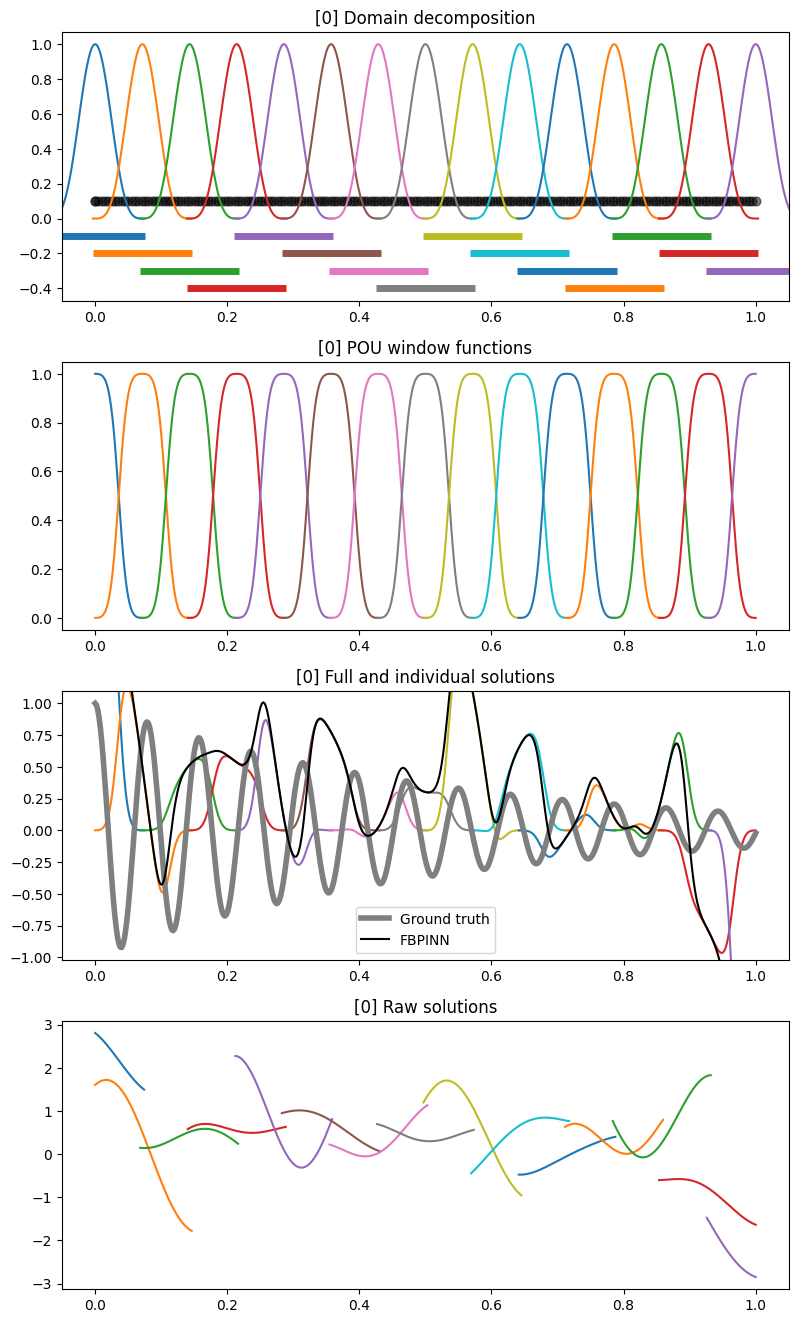

[INFO] 2025-03-07 16:43:54 - [i: 1000/20000] loss: 285822.1562 rate: 470.5 elapsed: 0.00 hr test
[INFO] 2025-03-07 16:43:55 - [i: 2000/20000] loss: 45875.2461 rate: 1239.8 elapsed: 0.00 hr test


KeyboardInterrupt: 

In [7]:
from fbpinns.trainers import FBPINNTrainer

run = FBPINNTrainer(c)
all_params = run.train()